# Jupyter Pipeline for Mouse Simulation

### Outputs Time Series Matrix, Time array and SCM vs FCM Spearson Correlation

In [1]:
# A copy of Basic Connectome Simulations, but edited to be nicer.
# Also added the final functionalities of Skeleton Pipeline

# First Import the packages.
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
from scipy import stats
#matplotlib.style.use('ggplot')

INFO  log level set to INFO


## Main adjustments below, can hopefully get away with only changing cell below!

In [62]:
# Main adjustments here:

# Name of import file/zip - Which contains connectivity data.
name = "3_2_BinCon"

# BOLD simulation or not? 
BOLD = True

# Snip is the the number of elements you wish to snip at the start to remove the initial condition effects.
Snip = 10 

# Define the model. 
MODEL = models.WilsonCowan()
#models.ReducedWongWang(w=1.0, I_o=0.3)

In [63]:
# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file("C:\\Users\\Pok Him\\Desktop\\MouseBrainModelling\\Connectomes\\" + name + ".zip")

# Mouse Allen Connectivity
#con = connectivity.Connectivity.from_file("../mouse/allen_2mm/Connectivity.h5")

if BOLD ==  True :
    
    name = name + "_BOLD"

else:
    name = name + "_nonBOLD"

WARNING  File 'hemispheres' not found in ZIP.


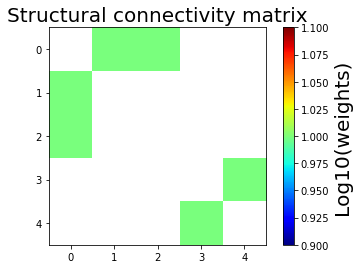

In [64]:
# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
#plt.yticks([0,1,2,3])

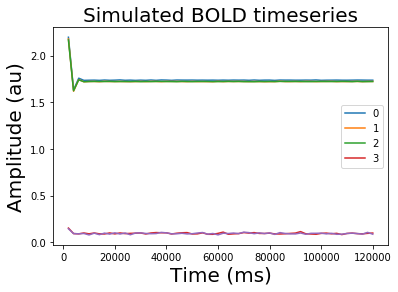

In [72]:
# Set the parameter of the resting state simulation

if BOLD == True:
    sim = simulator.Simulator(model=MODEL,
                            connectivity=con,
                            coupling=coupling.Linear(a=0.096),
                            integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=0.00013)),
                            monitors=(monitors.Bold(period=2e3),
                                      monitors.TemporalAverage(period=1e3)),
                            simulation_length=1.2e5,
                            #initial_conditions=[1.8,1.8,1.8,1.8,1.8]
                            ).configure()
    # Run the resting state simulation
    (bold_time, bold_data), _ = sim.run()

    # Display the simulated bold timeseries
    plt.subplots()
    plt.plot(bold_time,bold_data[:,0,:,0])
    plt.xlabel('Time (ms)', fontsize=20)
    plt.ylabel('Amplitude (au)', fontsize=20)
    plt.title('Simulated BOLD timeseries', fontsize=20)
    plt.legend(('0','1','2','3'))

else:

  sim = simulator.Simulator(model=MODEL,
                          connectivity=con,
                          coupling=coupling.Linear(a=0.096),
                          integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=0.000013)),
                          monitors=(monitors.TemporalAverage(period=1e3)),
                          simulation_length=1.2e5).configure()
  # Run the resting state simulation
  awer = sim.run()
  bold_time = awer[0][0]
  bold_data = awer[0][1]

  # Display the simulated non-bold timeseries
# Display the simulated non-bold timeseries
  plt.subplots()
  plt.plot(bold_time,bold_data[:,0,:,0])
  plt.xlabel('Time (ms)', fontsize=20)
  plt.ylabel('Amplitude (au)', fontsize=20)
  plt.title('Simulated non-BOLD timeseries', fontsize=20)
  plt.legend(('0','1','2','3','4'))

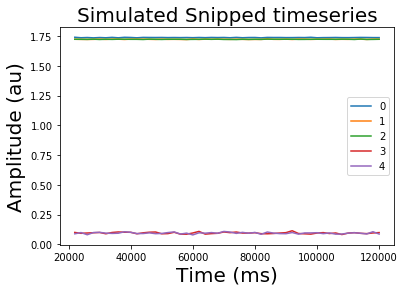

In [73]:
# Display the simulated snipped timeseries
plt.subplots()
plt.plot(bold_time[Snip:],bold_data[Snip:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated Snipped timeseries', fontsize=20)
plt.legend(('0','1','2','3','4'))

In [74]:
# Functional Connectivity Matrix. 

# We note that this is a static analysis.  More advanced version would be a DYnamic version with windowing.

# Convert Simulation output into a form usable by Numpy.
TSeriesMatrix = np.empty((bold_data.shape[2], bold_data.shape[0]-Snip))
#Matrix = []

for i in range(bold_data.shape[2]):
    TSeriesMatrix[i] = bold_data[Snip:,0,i].flatten()

# Functional Conenctivity MAtrix = Pearson Correlation.

FCM = np.corrcoef(TSeriesMatrix)
FCM

array([[ 1.00000000e+00,  6.83510088e-02, -1.52644284e-01,
         1.42676327e-01,  6.76616874e-02],
       [ 6.83510088e-02,  1.00000000e+00, -1.06821828e-01,
        -5.68351756e-02,  7.56166983e-05],
       [-1.52644284e-01, -1.06821828e-01,  1.00000000e+00,
        -8.39049431e-02,  7.63060893e-02],
       [ 1.42676327e-01, -5.68351756e-02, -8.39049431e-02,
         1.00000000e+00,  2.69056857e-01],
       [ 6.76616874e-02,  7.56166983e-05,  7.63060893e-02,
         2.69056857e-01,  1.00000000e+00]])

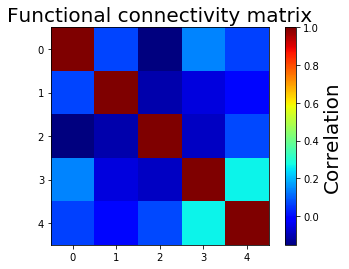

In [75]:
# Plot Matrix
cs=plt.imshow(FCM, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])

In [76]:
# Comparing SC Vs FC with Spearman Correlation

# Grab Upper triangles
FCM_Upper = FCM[np.triu_indices(FCM.shape[0], k = 1)]
SCM_Upper = con.weights[np.triu_indices(con.weights.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Upper,b=SCM_Upper)
SCorr

SpearmanrResult(correlation=0.11396057645963793, pvalue=0.7539236059777021)

Text(0,0,u'SpearmanrResult(correlation=0.11396057645963793, pvalue=0.7539236059777021)')

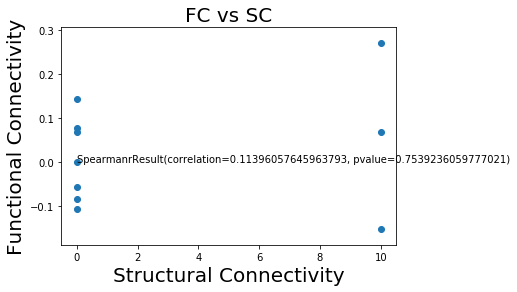

In [77]:
plt.scatter(SCM_Upper,FCM_Upper)
plt.xlabel('Structural Connectivity', fontsize=20)
plt.ylabel('Functional Connectivity', fontsize=20)
plt.title('FC vs SC', fontsize=20)
plt.text(x=0,y=0,s=SCorr)

In [78]:
# Export the simulation
np.savetxt("do-not-track\\" + name + "_TSM.csv", TSeriesMatrix, delimiter=",")
np.savetxt("do-not-track\\" + name + "_Time.csv", bold_time, delimiter = ",")
np.savetxt("do-not-track\\" + name + "_FCM.csv", FCM, delimiter = ",")
np.savetxt("do-not-track\\" + name + "_Scorr.csv", SCorr, delimiter = ",")